# 一、数据介绍

* 某赛季NBA球员数据

# 二、分析概述

* 从轮廓系数的维度看，该数据集分为两类最优  
* 对于聚类算法这类无监督的算法，具体分为几类需要根据实际需求确定

# 三、数据预处理

In [1]:
import findspark
findspark.init()

In [45]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [3]:
# 创建 SparkSession
spark = SparkSession.builder.appName("KMeans").master("local[*]").getOrCreate()

In [4]:
# 读取 CSV 数据
# header = True 代表读入数据的第一行是列名
# inferSchema=True 自动推断每列数据的数据类型，设为False就都当成字符串类型了
data = spark.read.csv("data.csv", header=True, inferSchema=True)

In [5]:
data.show()

+---+---------------+----+----+----+-----+----+----+-----+--------+--------+------+--------+--------+----+----+----+----+----+----+----+----+----+---+---+
|_c0|           球员|出场|首发|时间| 投篮|命中|出手| 三分|三分命中|三分出手|  罚球|罚球命中|罚球出手|篮板|前场|后场|助攻|抢断|盖帽|失误|犯规|得分| 胜| 负|
+---+---------------+----+----+----+-----+----+----+-----+--------+--------+------+--------+--------+----+----+----+----+----+----+----+----+----+---+---+
|  0|凯兰纳-阿祖布克| 208|  84|24.2|45.9%| 3.9| 8.4|40.9%|     1.0|     2.5| 77.0%|     1.8|     2.3| 4.0| 1.2| 2.8| 1.1| 0.6| 0.5| 1.0| 2.0|10.5| 99|109|
|  1|  古斯塔沃-阿永| 135|  41|16.7|53.6%| 2.1| 3.9| 0.0%|     0.0|     0.0| 50.4%|     0.5|     1.0| 4.4| 1.4| 3.0| 1.3| 0.7| 0.5| 0.9| 2.0| 4.7| 47| 88|
|  2|  德尼斯-沃特雷| 733|    |19.3|45.9%| 1.9| 4.1|     |        |        | 65.2%|     1.0|     1.6| 4.6|    |    | 2.0|    |    |    | 2.3| 4.8|   |   |
|  3|    威廉-艾弗里| 142|   1| 8.5|33.0%| 1.0| 2.9|25.5%|     0.3|     1.1| 71.4%|     0.5|     0.6| 0.7| 0.1| 0.5| 1.4| 0.2| 0.0| 0.7| 0.9| 2.7| 8

## 缺失值处理

* 计算每列的空值数量，经过对数据的初步分析得知，数据集中空格代表空值

In [6]:
# 计算DataFrame中每一列的缺失率
def calculate_missing_rates(df):
    """
    计算每列的缺失率（为 null 和 空格 都认为是缺失值）

    Parameters:
    - df: PySpark DataFrame

    Returns:
    - missing_rates_df: PySpark DataFrame，包含每列的缺失率
    """
    total_rows = df.count()
    missing_rates = []

    for column in df.columns:
        missing_count = df.filter(col(column).isNull() | (col(column) == " ")).count()
        missing_rate = (missing_count / total_rows) * 100
        missing_rates.append((column, missing_rate))

    # 创建 DataFrame 显示结果
    missing_rates_df = spark.createDataFrame(missing_rates, ["Column", "MissingRate"])
    return missing_rates_df

In [9]:
missing_rates = calculate_missing_rates(data)

In [10]:
missing_rates.show()

+--------+------------------+
|  Column|       MissingRate|
+--------+------------------+
|     _c0|               0.0|
|    球员|               0.0|
|    出场|               0.0|
|    首发| 37.10832587287377|
|    时间| 9.937332139659803|
|    投篮|0.6490599820948971|
|    命中|               0.0|
|    出手|               0.0|
|    三分| 42.79319606087735|
|三分命中|34.064458370635634|
|三分出手|34.064458370635634|
|    罚球| 4.767233661593554|
|罚球命中|               0.0|
|罚球出手|               0.0|
|    篮板| 9.288272157564906|
|    前场|26.029543419874663|
|    后场|26.007162041181736|
|    助攻|               0.0|
|    抢断| 26.16383169203223|
|    盖帽| 26.16383169203223|
+--------+------------------+
only showing top 20 rows



In [11]:
# 过滤出缺失率超过80%的特征，认为这部分特征无法参与建模，删除
missing_rates.filter(col("MissingRate") > 80).show()

+------+-----------+
|Column|MissingRate|
+------+-----------+
+------+-----------+



In [20]:
# 对于其他有缺失值但是缺失率小于0.8的进行数据填充
# 找出需要填充的列
missing_rates_list = missing_rates.filter(col("MissingRate") > 0).select("Column").collect()
columns_to_fill = [row["Column"] for row in missing_rates_list]

In [21]:
columns_to_fill

['首发',
 '时间',
 '投篮',
 '三分',
 '三分命中',
 '三分出手',
 '罚球',
 '篮板',
 '前场',
 '后场',
 '抢断',
 '盖帽',
 '失误',
 '胜',
 '负']

根据数据含义确定填充策略  
* '首发'列采用，0值填充  
*  其他的特征列，均采用均值填充策略

In [24]:
# 只有数字类型的数据才能代入建模，首先把几个百分比的数字改成数字类型
# 去掉百分号并转换为浮点数
for col in ['投篮','三分','罚球']:
    data = data.withColumn(
        col,
        F.expr(f"CAST(REGEXP_REPLACE(`{col}`, '%', '') AS FLOAT)")
    )

In [27]:
# 去除每列中的空格数据并计算它们的均值
columns_to_fill.append("_c0")
data_no_empty_strings = data.select([F.col(c).cast(FloatType()) if c not in ["首发","_c0"] else F.col(c) for c in [*columns_to_fill]])
# 计算均值
mean_values = data_no_empty_strings.agg(*[F.mean(c).alias(c) for c in data_no_empty_strings.columns if c not in ["首发","_c0"]]).collect()[0]

In [28]:
# 使用均值替换空格
data_filled = data_no_empty_strings.na.fill(mean_values.asDict())

In [29]:
# 用 0填充：'首发'
data_filled = data_filled.withColumn("首发", F.when(data_filled["首发"] == " ", 0).otherwise(data_filled["首发"]))

In [30]:
# '首发' 转换成数字类型，只有数字类型才能参与建模
data_filled = data_filled.withColumn("首发", col("首发").cast("int"))

In [31]:
data_filled.show()

+----+---------+----+---------+----------+---------+--------+---------+---------+---------+----------+----------+---------+---------+---------+---+---+
|首发|     时间|投篮|     三分|  三分命中| 三分出手|    罚球|     篮板|     前场|     后场|      抢断|      盖帽|     失误|       胜|       负|_c0|_c0|
+----+---------+----+---------+----------+---------+--------+---------+---------+---------+----------+----------+---------+---------+---------+---+---+
|  84|     24.2|45.9|     40.9|       1.0|      2.5|    77.0|      4.0|      1.2|      2.8|       0.6|       0.5|      1.0|     99.0|    109.0|  0|  0|
|  41|     16.7|53.6|      0.0|       0.0|      0.0|    50.4|      4.4|      1.4|      3.0|       0.7|       0.5|      0.9|     47.0|     88.0|  1|  1|
|   0|     19.3|45.9|24.931887|0.35254583|1.0626951|    65.2|      4.6|0.8444478|1.9524199|0.53767806|0.31770232|0.9910995|137.24385|139.66055|  2|  2|
|   1|      8.5|33.0|     25.5|       0.3|      1.1|    71.4|      0.7|      0.1|      0.5|       0.2|       0.0|      0

In [33]:
# 把data中其他的数字类型的列拼接到data_filled中构造最后参与建模的数据集
filtered_data = data.select(['出场','命中','出手','罚球命中','助攻','犯规','得分', '_c0'])
data_filled = data_filled.join(filtered_data, on='_c0')

## 重复值处理

In [34]:
data_filled = data_filled.dropDuplicates()

# 四、模型搭建

In [38]:
# 构造进行聚类建模的向量数据
assembler = VectorAssembler(inputCols=[ '首发','时间','投篮','三分','三分命中','三分出手','罚球','篮板','前场',
 '后场','抢断','盖帽','失误','胜','负','出场','命中','出手','罚球命中','助攻','犯规','得分'], outputCol="features")
final_data = assembler.transform(data_filled)

In [41]:
# 构造自定义函数，用于绘制不同k值和对应轮廓系数的折线图
def k_silhouette(X, clusters):
    K = range(2,clusters+1)
    # 构建空列表，用于存储个中簇数下的轮廓系数
    S = []
    for k in K:
        kmeans = KMeans().setK(k) \
        .setSeed(1) \
        .setMaxIter(200) \
        .setInitMode("k-means||") \
        .setInitSteps(3) \
        .setTol(1e-4) \
        .setDistanceMeasure("euclidean") \
        .setFeaturesCol("features") \
        .setPredictionCol("prediction")
        model = kmeans.fit(X)
        predictions = model.transform(X)
        # 使用 ClusteringEvaluator 计算轮廓系数
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        S.append(silhouette)

    # 中文和负号的正常显示
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    # 设置绘图风格
    plt.style.use('ggplot')
    # 绘制K的个数与轮廓系数的关系
    plt.plot(K, S, 'b*-')
    plt.xlabel('簇的个数')
    plt.ylabel('轮廓系数')
    # 显示图形
    plt.show()

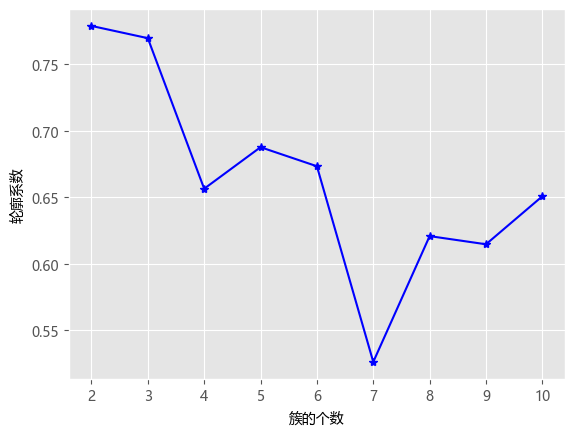

In [46]:
k_silhouette(final_data, 10)

In [47]:
# 观察上图发现在k=2的时候聚类效果最好
# 用k=2对模型进行重建
kmeans = KMeans().setK(2) \
        .setSeed(1) \
        .setMaxIter(200) \
        .setInitMode("k-means||") \
        .setInitSteps(3) \
        .setTol(1e-4) \
        .setDistanceMeasure("euclidean") \
        .setFeaturesCol("features") \
        .setPredictionCol("prediction")

In [48]:
model = kmeans.fit(final_data)
predictions = model.transform(final_data)

In [49]:
predictions.show()

+----+----+---------+----+---------+----------+---------+--------+---------+---------+---------+----------+----------+---------+---------+---------+----+----+----+--------+----+----+----+--------------------+----------+
| _c0|首发|     时间|投篮|     三分|  三分命中| 三分出手|    罚球|     篮板|     前场|     后场|      抢断|      盖帽|     失误|       胜|       负|出场|命中|出手|罚球命中|助攻|犯规|得分|            features|prediction|
+----+----+---------+----+---------+----------+---------+--------+---------+---------+---------+----------+----------+---------+---------+---------+----+----+----+--------+----+----+----+--------------------+----------+
|  35| 710|     29.7|42.2|     35.1|       1.4|      4.1|    72.8|      4.8|      1.0|      3.8|       1.5|       0.3|      1.4|    569.0|    460.0|1029| 3.8| 9.0|     1.6| 2.2| 2.0|10.6|[710.0,29.7000007...|         1|
| 185|  51|     13.5|37.8|     36.2|       0.3|      0.8|    69.3|      1.3|      0.3|      1.1|       0.6|       0.1|      1.1|    166.0|    171.0| 337| 1.2| 3.1|     

In [50]:
# 获取中心点
centers = model.clusterCenters()

In [51]:
centers

[array([ 15.12689902,  13.09127881,  38.96014896,  24.34886478,
          0.29938027,   0.92995396,  67.98351673,   2.33398163,
          0.71655345,   1.60751094,   0.45035375,   0.25838588,
          0.84604632,  87.71902772,  95.08574009, 117.00327674,
          1.77706285,   4.47929699,   0.93098004,   1.04837653,
          1.54986595,   4.65347036]),
 array([3.05799280e+02, 2.56718715e+01, 4.60292530e+01, 2.66935448e+01,
        5.13190995e-01, 1.46378628e+00, 7.50709272e+01, 4.75554821e+00,
        1.23089365e+00, 2.99459736e+00, 8.01537464e-01, 4.96933066e-01,
        1.42939241e+00, 2.86888172e+02, 2.74347906e+02, 7.46619262e+02,
        4.30387039e+00, 9.36084608e+00, 2.22547255e+00, 2.52169217e+00,
        2.39486949e+00, 1.12643564e+01])]